# Implementing ResNets in PyTorch from Scratch

**Important note:** This project's written material has a lot of personal views and observations mixed in with the actual information being presented. This is done so that I can voice out what's going on in my head while working on this project. I will try to keep things as objective as possible when working here

Here we will look at the implementation of ResNets in PyTorch. I would normally consider doing this from scratch in NumPy/Pandas, however, owing to the complexity of this model and ones after this, it made more sense to use either PyTorch or Tensorflow.

As for my reason for choosing PyTorch, this library has seen a lot of use in modern deep learning model development, especially in the field of generative AI and LLMs. Tensorflow, though just as capable, has fallen behind a bit in comparison, but is still a pretty capable library to use.

I will be using Netron to try and visualize the network we are building. 

In [ ]:
import numpy as np
import h5py
import gc
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Here, I am importing all the libraries that I will be using for this mini project. Since my laptop is pretty dated, I will not be able to take advantage of its CUDA capabilities. I have a GTX 1650, and the closest graphics card in this series that supports CUDA is the GTX 1650Ti. Your results may vary.

# Loading the dataset

The process of loading a "custom dataset" (as is described in the documentation) in PyTorch seems a bit tedious at first. It requires the creation of a `Dataset` class that consists of
- `__init__(self, ...)` to initialize the dataset
- `__len__(self)` to return the count of the number of samples in the dataset
- `__getitem__(self, index)`, which returns the index of an example as is needed by us 

This class is used by PyTorch's `DataLoader` to load the dataset in batches. From what I understand, this trivializes the process of loading the dataset while augmenting, shuffling and performing more preprocessing tasks on it.

It makes sense as opposed to performing all these tasks from the ground-up, and minimizes the chance of user error as well. This, however, adds to the growing pains of getting used to this framework, and it will take me a while to adapt to it.

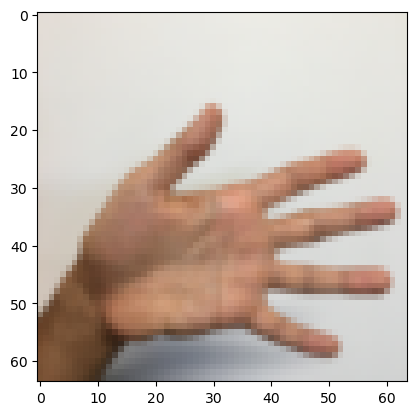

In [2]:
with h5py.File('./datasets/train_signs.h5', 'r') as f:
    plt.imshow(f["train_set_x"][0])

    

In [3]:
class dataset(Dataset):
    def __init__(self, h5_file, data, labels, transform=None):
        self.h5_file = h5py.File(h5_file,"r")
        self.data = self.h5_file[data][:]
        self.labels = self.h5_file[labels][:]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        data = self.data[idx]
        labels = self.labels[idx]

        if self.transform:
            data = self.transform(data)

        return data, labels

In [4]:
normalize = transforms.Normalize(
      mean=[0.4914, 0.4822, 0.4465],
      std=[0.2023, 0.1994, 0.2010],
  )

# The inputs for the ResNet34 architecture need to be at 225x225 for the ideal performance of the model.
transform = transforms.transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

train_dataset = dataset("./datasets/train_signs.h5", "train_set_x", "train_set_y", transform)
test_dataset = dataset("./datasets/test_signs.h5", "test_set_x", "test_set_y", transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

It works! We can now use this data loader to load up our training and validation/testing datasets. We can now focus on building our model.

Building deep learning models in PyTorch is done through its `nn.Module`. This is the main boilerplate that we use for designing and training custom models from scratch.

Again, being the PITA it is, this module has a `__init__` function for defining the layers we can add to our network. It also contains the `forward` function to define the sequence of the layers being executed on the input.

Some of the commonly used layers/functions are `nn.Conv2d`, `nn.BatchNorm2d`, `nn.ReLU`, `nn.MaxPool2d`, `nn.Dropout`, `nn.Linear`, `nn.Sequential`.

## The Residual Block

We will now focus on building the Residual block for our ResNet architecture 

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__() # This gives access to parent attributes and methods, and is used here to initialize the parent class attributes
        
        # This is the first convolution layer of the form CONV -> Batch Norm -> ReLU.
        # This takes the input channels, putting them through the three operations above to give us the output channels
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())
        
        # This is the second convolution layer that takes the output channels from the first convolution and operates on it.
        # The order here is similar to before but we have not included the activation function to accommodate the
        # residual/forward skip connection.
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels))
        
        self.downsample = downsample # This is another term for pooling and can be either max pooling or average pooling
        self.relu = nn.ReLU()
        self.out_channels = out_channels
    
    # Now comes the interesting part, the implementation of the skip connection, which we call `forward` here
    def forward(self, X):
        
        residual = X

        # This is equivalent to CONV1/BatchNorm/Activation -> CONV2/BatchNorm.
        # The residual is added to the linear part here

        out = self.conv1(X)
        out = self.conv2(out)

        if self.downsample:
            residual = self.downsample(X)
        
        # The out here is the linear part output from before. The downsampling, if any, is applied before this
        out += residual

        out = self.relu(out)

        return out

# The ResNet Model
With this, we can now build our ResNet model. The state of the art model that was introduced in the original ResNet paper used 34 layers in a row with skip connections, hence giving it the name **ResNet34**. We will now build this model up to use with our current dataset.

I have added comments in the code to explain exactly what is happening.


In [6]:
class ResNet(nn.Module):
    def __init__(self, resBlock, num_layers, num_classes=6):
        super(ResNet, self).__init__()
        self.inchannels = 64

        # This is the first 7x7 layer in the ResNet34 architecture followed by the maxpool
        # to bring down the dimensions of the feature maps to half the original value
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        # Remember: The output size here is (n + 2p - f)/s => (n + 2 - 3)/2 => (n-1)/2,
        # which is more or less half the original dimensions. 
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # From here we make the residual layers using the _make_res_layer() constructor
        self.res0 = self._make_res_layer(resBlock, 64, num_layers[0], stride=1)
        self.res1 = self._make_res_layer(resBlock, 128, num_layers[1], stride=2)
        self.res2 = self._make_res_layer(resBlock, 256, num_layers[2], stride=2)
        self.res3 = self._make_res_layer(resBlock, 512, num_layers[3], stride=2)

        # This model also implements average pooling towards the deeper layers,
        # right before the output prediction layer
        self.avgpool = nn.AvgPool2d(7, stride=1)

        # This is the final output layer
        self.fc = nn.Linear(512, num_classes)
    
    def _make_res_layer(self, block, number_channels, number_blocks, stride=1):
        downsample = None
        # Downsampling is performed for layers which have a stride greater than 1.
        # The second condition here allows us to ignore the very first 7x7 convolution layer
        # since we initialize inchannels to 64.
        # The first condition handles all the cases for convolution layers deeper into the
        # network with strides=2 (basically the Residual blocks).
        if stride != 1 or self.inchannels != number_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.inchannels, number_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(number_channels)
            )
        
        layers = []
        layers.append(block(self.inchannels, number_channels, stride, downsample))
        self.inchannels = number_channels
        for i in range(1, number_blocks):
            layers.append(block(self.inchannels, number_channels))

        self.inchannels = number_channels

        # here we unpack the list, create a sequential block which represents the whole model
        return nn.Sequential(*layers)
    
    def forward(self, X):
        X = self.conv1(X)
        X = self.maxpool(X)
        X = self.res0(X)
        X = self.res1(X)
        X = self.res2(X)
        X = self.res3(X)
        X = self.avgpool(X)

        # Unwrapping the resultant layer into a 1D tensor
        X = X.view(X.size(0), -1)
        X = self.fc(X)

        return X


The above class can now be used to define the structure of our model. We have free rein over the type and number of blocks we use in our final model through the `block` and `num_layers` parameters respectively.

## Setting up the hyperparameters

Looking at our current use case, we have 6 classes to work with, so we'll have to ensure that we set the number of classes for our model accordingly. The rest of the parameters can be messed around with to see what works best.

For the original ResNet34 architecture, the number of residual blocks used are:

| Type    | Number of blocks |
| ------- | ---------------- |
| 3x3,64  | 3                |
| 3x3,128 | 4                |
| 3x3,256 | 6                |
| 3x3,512 | 3                |

Hence, the number of residual layers are set accordingly.

In [7]:
num_classes = 6
epochs = 30
batch_size = 32
learning_rate = 0.002

model = ResNet(resBlock=ResidualBlock, num_layers=[3,4,6,3], num_classes=6).to(device)

losstype = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Count of steps
total_step = len(train_dataloader)

We will now proceed with training our network

In [8]:
quit = 0
for epoch in range(epochs):
    for i, (data, labels) in enumerate(train_dataloader):
        # If we weren't broke and had a CUDA supported GPU,
        # this would move the data to GPU. Sadly, we'll have to make do with CPU
        data = data.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(data)
        loss = losstype(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        # The above is needed for backprop with mini batches.
        # Source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        loss.backward() # This performs backward propagation throughout the network
        optimizer.step() # This performs a single optimization step and updates the parameters

        del data, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss={loss.item()}")

    # Validating with the test/validation set
    with torch.no_grad():
        correct = 0
        total = 0
        for data, labels in test_dataloader:
            data = data.to(device)
            labels = labels.to(device)

            outputs = model(data)

            _, prediction = torch.max(outputs.data,1)

            total += labels.size(0)
            correct += (prediction == labels).sum().item()
            del data, labels, outputs
        if 100*(correct/total) > 99:
            quit = 1
        print(f"Validation Accuracy = {100*(correct/total)}")
    if quit == 1:
        break


Epoch [1/30], Loss=1.0083532333374023
Validation Accuracy = 54.166666666666664
Epoch [2/30], Loss=0.6827556490898132
Validation Accuracy = 75.83333333333333
Epoch [3/30], Loss=0.42067763209342957
Validation Accuracy = 81.66666666666667
Epoch [4/30], Loss=0.376005083322525
Validation Accuracy = 88.33333333333333
Epoch [5/30], Loss=0.34077224135398865
Validation Accuracy = 91.66666666666666
Epoch [6/30], Loss=0.41830411553382874
Validation Accuracy = 90.83333333333333
Epoch [7/30], Loss=0.5857784748077393
Validation Accuracy = 85.83333333333333
Epoch [8/30], Loss=0.35487672686576843
Validation Accuracy = 89.16666666666667
Epoch [9/30], Loss=0.2685949206352234
Validation Accuracy = 88.33333333333333
Epoch [10/30], Loss=0.22276091575622559
Validation Accuracy = 89.16666666666667
Epoch [11/30], Loss=0.2646466791629791
Validation Accuracy = 86.66666666666667
Epoch [12/30], Loss=0.18142181634902954
Validation Accuracy = 95.83333333333334
Epoch [13/30], Loss=0.28394049406051636
Validation Accu

Running this code for the first time took approximately 49 minutes, and it has a validation accuracy of 92.5%. I did however notice that this model achieved a validation accuracy of 99% at the 17th epoch in one of my runs, so achieving a good amount of accuracy isn't as far-fetched as one may think.

Another interesting observation is the accuracy values here. We used the Adam Optimizer to train our model, and based on previous independent study, we notice how this optimization algorithm tends to oscillate about the minimum, or in this case the maximum, since we are considering the accuracy. I would not be surprised if it went up to 99% if we went for a few more epochs, but I would avoid training it too much as it would lead to overfitting the data and that is no bueno.

With 34 layers, this model would have 63.5 million parameters to work with.

I will now save this model so that I or anyone else running this code won't have to torture a laptop every time THEY want access to it.

In [9]:
for param in model.state_dict():
    print(param, "\t", model.state_dict()[param].size())

conv1.0.weight 	 torch.Size([64, 3, 7, 7])
conv1.0.bias 	 torch.Size([64])
conv1.1.weight 	 torch.Size([64])
conv1.1.bias 	 torch.Size([64])
conv1.1.running_mean 	 torch.Size([64])
conv1.1.running_var 	 torch.Size([64])
conv1.1.num_batches_tracked 	 torch.Size([])
res0.0.conv1.0.weight 	 torch.Size([64, 64, 3, 3])
res0.0.conv1.0.bias 	 torch.Size([64])
res0.0.conv1.1.weight 	 torch.Size([64])
res0.0.conv1.1.bias 	 torch.Size([64])
res0.0.conv1.1.running_mean 	 torch.Size([64])
res0.0.conv1.1.running_var 	 torch.Size([64])
res0.0.conv1.1.num_batches_tracked 	 torch.Size([])
res0.0.conv2.0.weight 	 torch.Size([64, 64, 3, 3])
res0.0.conv2.0.bias 	 torch.Size([64])
res0.0.conv2.1.weight 	 torch.Size([64])
res0.0.conv2.1.bias 	 torch.Size([64])
res0.0.conv2.1.running_mean 	 torch.Size([64])
res0.0.conv2.1.running_var 	 torch.Size([64])
res0.0.conv2.1.num_batches_tracked 	 torch.Size([])
res0.1.conv1.0.weight 	 torch.Size([64, 64, 3, 3])
res0.1.conv1.0.bias 	 torch.Size([64])
res0.1.conv1.1.

In [10]:
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

state 	 {0: {'step': tensor(1020.), 'exp_avg': tensor([[[[-1.0349e-06, -6.7701e-07, -3.9311e-07,  ...,  1.1416e-07,
            4.3485e-07,  4.3814e-07],
          [-1.6009e-06, -1.3124e-06, -1.0056e-06,  ..., -4.5859e-07,
           -7.0441e-08,  5.9123e-08],
          [-1.9168e-06, -1.6871e-06, -1.4059e-06,  ..., -8.0631e-07,
           -3.5426e-07, -1.4541e-07],
          ...,
          [-2.5287e-06, -2.3692e-06, -2.2363e-06,  ..., -1.6720e-06,
           -1.1041e-06, -7.8466e-07],
          [-2.8154e-06, -2.7155e-06, -2.5821e-06,  ..., -2.0333e-06,
           -1.4690e-06, -1.0723e-06],
          [-2.9977e-06, -2.8964e-06, -2.8160e-06,  ..., -2.2552e-06,
           -1.6818e-06, -1.2903e-06]],

         [[-4.2096e-07, -2.1223e-07,  3.9382e-08,  ...,  5.1511e-07,
            8.4886e-07,  9.7304e-07],
          [-6.1094e-07, -4.4777e-07, -2.3117e-07,  ...,  2.4086e-07,
            6.7551e-07,  8.6982e-07],
          [-4.8111e-07, -3.6359e-07, -2.2421e-07,  ...,  2.4568e-07,
           

In [11]:
# Only uncomment this if you want to save the model.
# I've commented it out to prevent any rewriting of my current model by accident
torch.save(model.state_dict(),"./models/resnet2.pth")

In [8]:
model1 = ResNet(resBlock=ResidualBlock, num_layers=[3,4,6,3], num_classes=6).to(device)
model1.load_state_dict(torch.load("./models/resnet2.pth"))

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))


Accuracy of the network on the 10000 test images: 98.33333333333333 %


## Visualizing what the layers have learned

Now, what interests me the most is knowing what the neural network here has learned. And, now that I have saved the model and am able to load it up at any time that I want, I can now focus on visualizing this without having to run every single one of the previous cells

What I want to see here is the object structure that the model's weights and biases are saved in, which can easily be accessed using the `model.state_dict()`.

But first, I want to visualize the given model with a desktop web application called `netron`. This requires the use of the model in a file format known as `onnx` .

Onnx was a pain to get running because.... it's a pain. Normal installations of it will give you a DLL error. So it's highly advised to use an older version. The installation for it can be done through the following commands.

```bash
python -m pip install onnxruntime==1.18.0
python -m pip install onnx==1.16.1
```

In [9]:
# Only run the code below for saving the model structure
# This was commented out for the same reason as before

import onnx
model1.eval()
# test_dataloader1 = torch.utils.data.DataLoader(test_dataset)
data, target = next(iter(test_dataloader))
torch.onnx.export(model1, data, './models/resnet2.onnx', input_names=["Hand Signs"], output_names=["Number Presented"])

In [10]:
import netron
netron.start("./models/resnet2.onnx")

Serving './models/resnet2.onnx' at http://localhost:8080


('localhost', 8080)

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 64143)
----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 64142)
Traceback (most recent call last):
  File "c:\Users\ashis\anaconda3\Lib\socketserver.py", line 691, in process_request_thread
    self.finish_request(request, client_address)
  File "c:\Users\ashis\anaconda3\Lib\socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "c:\Users\ashis\anaconda3\Lib\socketserver.py", line 755, in __init__
    self.handle()
  File "c:\Users\ashis\anaconda3\Lib\http\server.py", line 436, in handle
    self.handle_one_request()
  File "c:\Users\ashis\anaconda3\Lib\http\server.py", line 424, in handle_one_request
    method()
  File "c:\Users\ashis\anaconda3\Lib\site-packages\netron\server.py", line 110, in do_GET
    self._write(status_code, content_type, content)
  File "c:\U

The code above displays the whole network in the browser using `netron`, so make sure you have installed it using
```bash
python -m pip install netron
```

NOW!! We'll visualize what some of the layers would be gleaning from the network.

In [15]:
for param in model.state_dict():
    print(param, "\t", model.state_dict()[param].size())

conv1.0.weight 	 torch.Size([64, 3, 7, 7])
conv1.0.bias 	 torch.Size([64])
conv1.1.weight 	 torch.Size([64])
conv1.1.bias 	 torch.Size([64])
conv1.1.running_mean 	 torch.Size([64])
conv1.1.running_var 	 torch.Size([64])
conv1.1.num_batches_tracked 	 torch.Size([])
res0.0.conv1.0.weight 	 torch.Size([64, 64, 3, 3])
res0.0.conv1.0.bias 	 torch.Size([64])
res0.0.conv1.1.weight 	 torch.Size([64])
res0.0.conv1.1.bias 	 torch.Size([64])
res0.0.conv1.1.running_mean 	 torch.Size([64])
res0.0.conv1.1.running_var 	 torch.Size([64])
res0.0.conv1.1.num_batches_tracked 	 torch.Size([])
res0.0.conv2.0.weight 	 torch.Size([64, 64, 3, 3])
res0.0.conv2.0.bias 	 torch.Size([64])
res0.0.conv2.1.weight 	 torch.Size([64])
res0.0.conv2.1.bias 	 torch.Size([64])
res0.0.conv2.1.running_mean 	 torch.Size([64])
res0.0.conv2.1.running_var 	 torch.Size([64])
res0.0.conv2.1.num_batches_tracked 	 torch.Size([])
res0.1.conv1.0.weight 	 torch.Size([64, 64, 3, 3])
res0.1.conv1.0.bias 	 torch.Size([64])
res0.1.conv1.1.

In [16]:
model1.state_dict()['res0.0.conv1.0.weight'][0].shape



torch.Size([64, 3, 3])

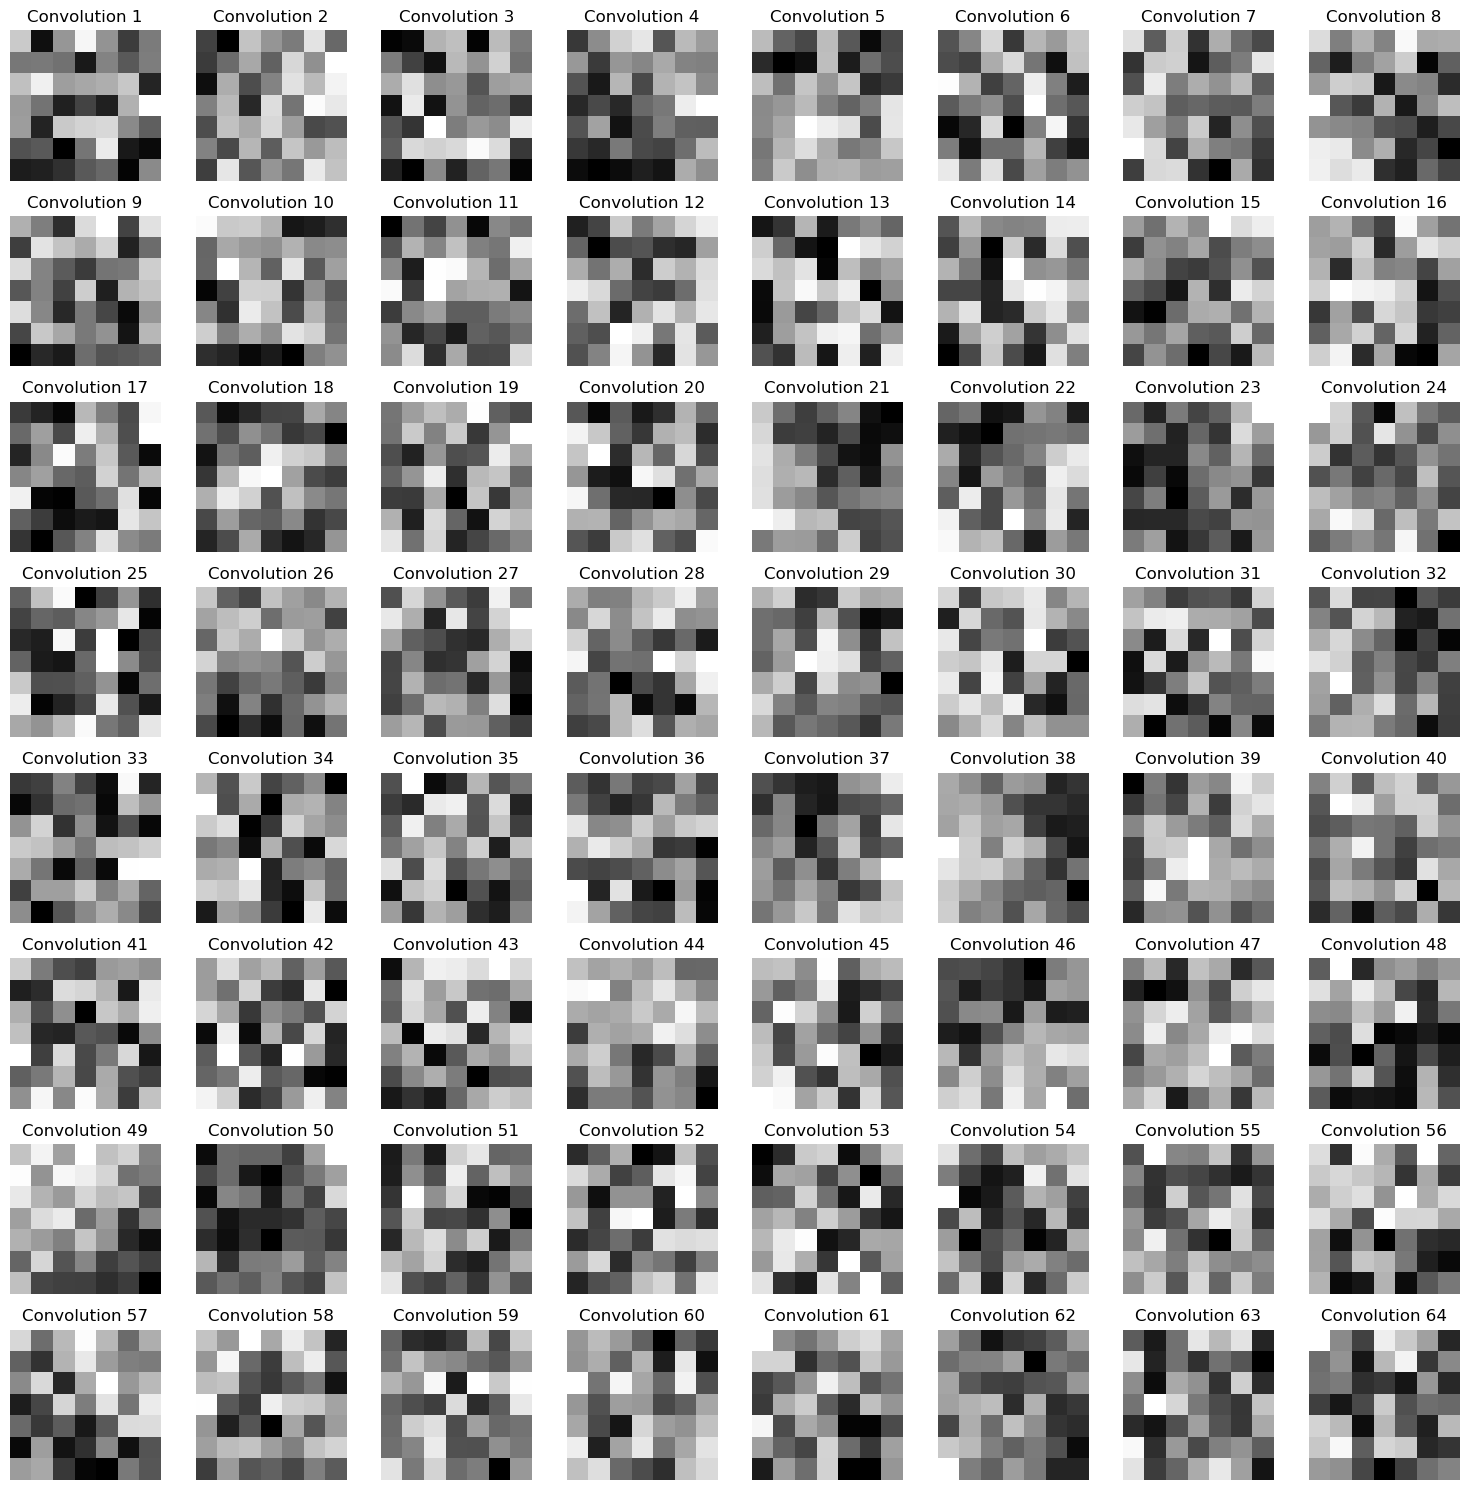

In [17]:
values = np.array(model1.state_dict()['conv1.0.weight'])

fig, ax = plt.subplots(8,8,figsize=(15,15))

for i, ax in enumerate(ax.flat):
    if i < values.shape[0]:
        plt.gray()
        ax.imshow(values[i][0].T)
        ax.set_title(f'Convolution {i+1}')
        ax.axis('off')

# fig.colorbar(heatmap, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1)

plt.tight_layout()
plt.show()

This doesn't seem to make a lot of sense to us in the beginning, however that doesn't matter because we are looking at the kernels/filters that our model is applying on the inputs. If we wanted to visualize what our model has actually understood from the image (even if it is difficult to put into words because neural networks are goofy that way), we would want to see the outputs of the convolution layers during the forward propagation process.

This is done with the help of the following solution

[source](https://stackoverflow.com/questions/52796121/how-to-get-the-output-from-a-specific-layer-from-a-pytorch-model)

In [18]:
from torchvision.models.feature_extraction import create_feature_extractor


model1.conv1

return_nodes = {"conv1.0":"conv1", "conv1.2":"relu1", "res0":"res0", "res1":"res1", "res2":"res2", "res3":"res3"}

model2 = create_feature_extractor(model1, return_nodes=return_nodes)

images,Y = next(iter(test_dataloader))

outputs = model2(images) 

In [19]:
labels = Y.numpy()

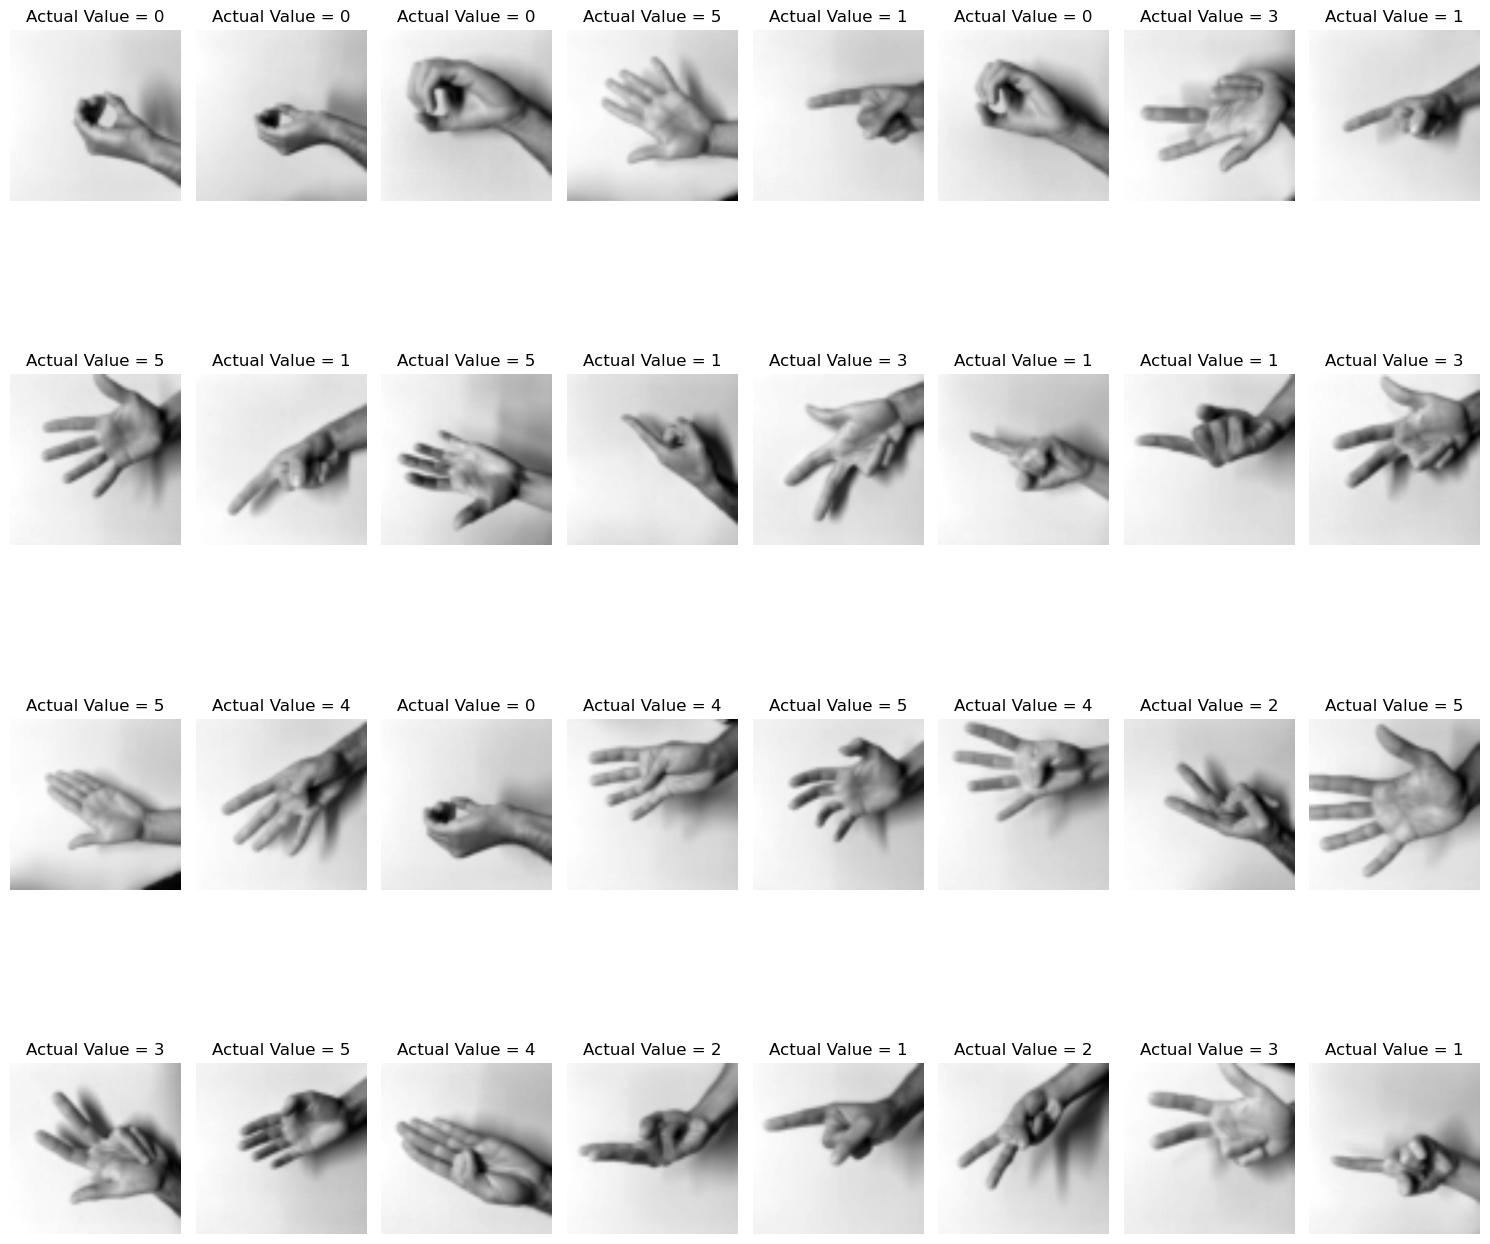

In [20]:
values = images.numpy()


fig, ax = plt.subplots(4,8,figsize=(15,15))

for i, ax in enumerate(ax.flat):
    if i < values.shape[0]:
        # plt.gray()
        ax.imshow(values[i][0].T)
        ax.set_title(f'Actual Value = {labels[i]}')
        ax.axis('off')


plt.tight_layout()
plt.show()

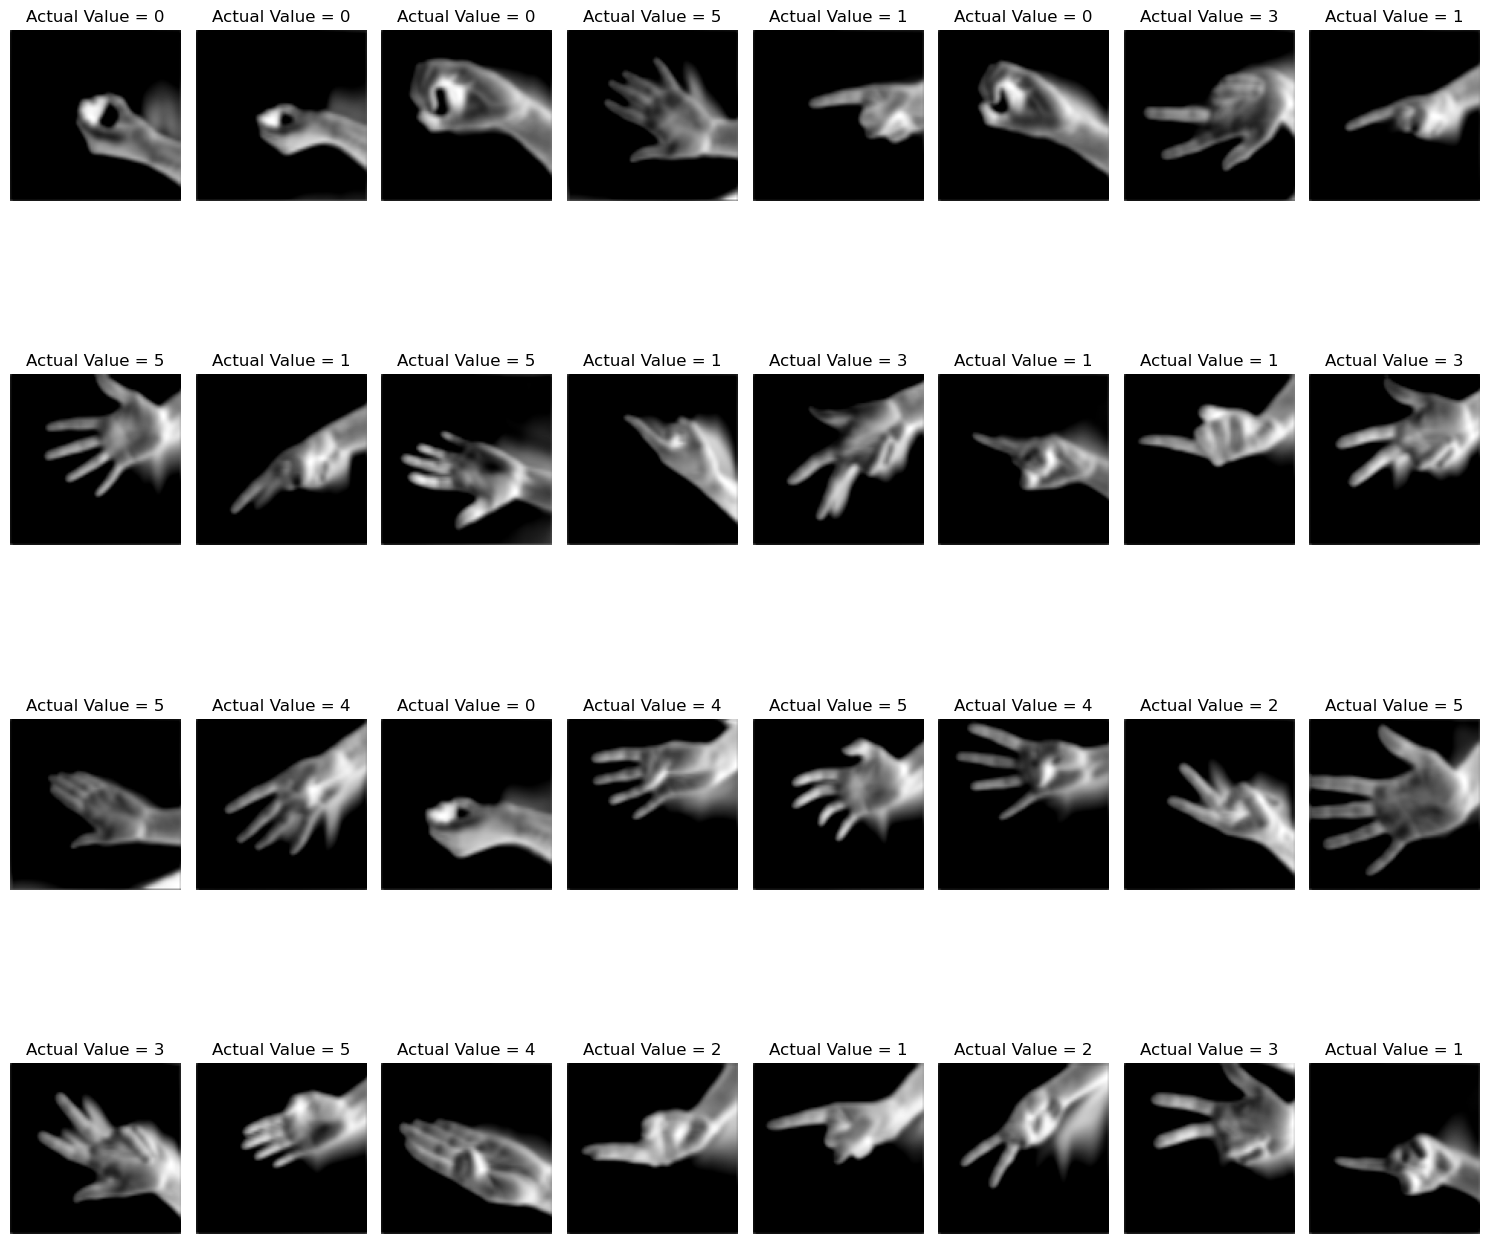

In [21]:
values = outputs["relu1"].detach().numpy()

fig, ax = plt.subplots(4,8,figsize=(15,15))

for i, ax in enumerate(ax.flat):
    if i < values.shape[0]:
        # plt.gray()
        ax.imshow(values[i][0].T)
        ax.set_title(f'Actual Value = {labels[i]}')
        ax.axis('off')


plt.tight_layout()
plt.show()

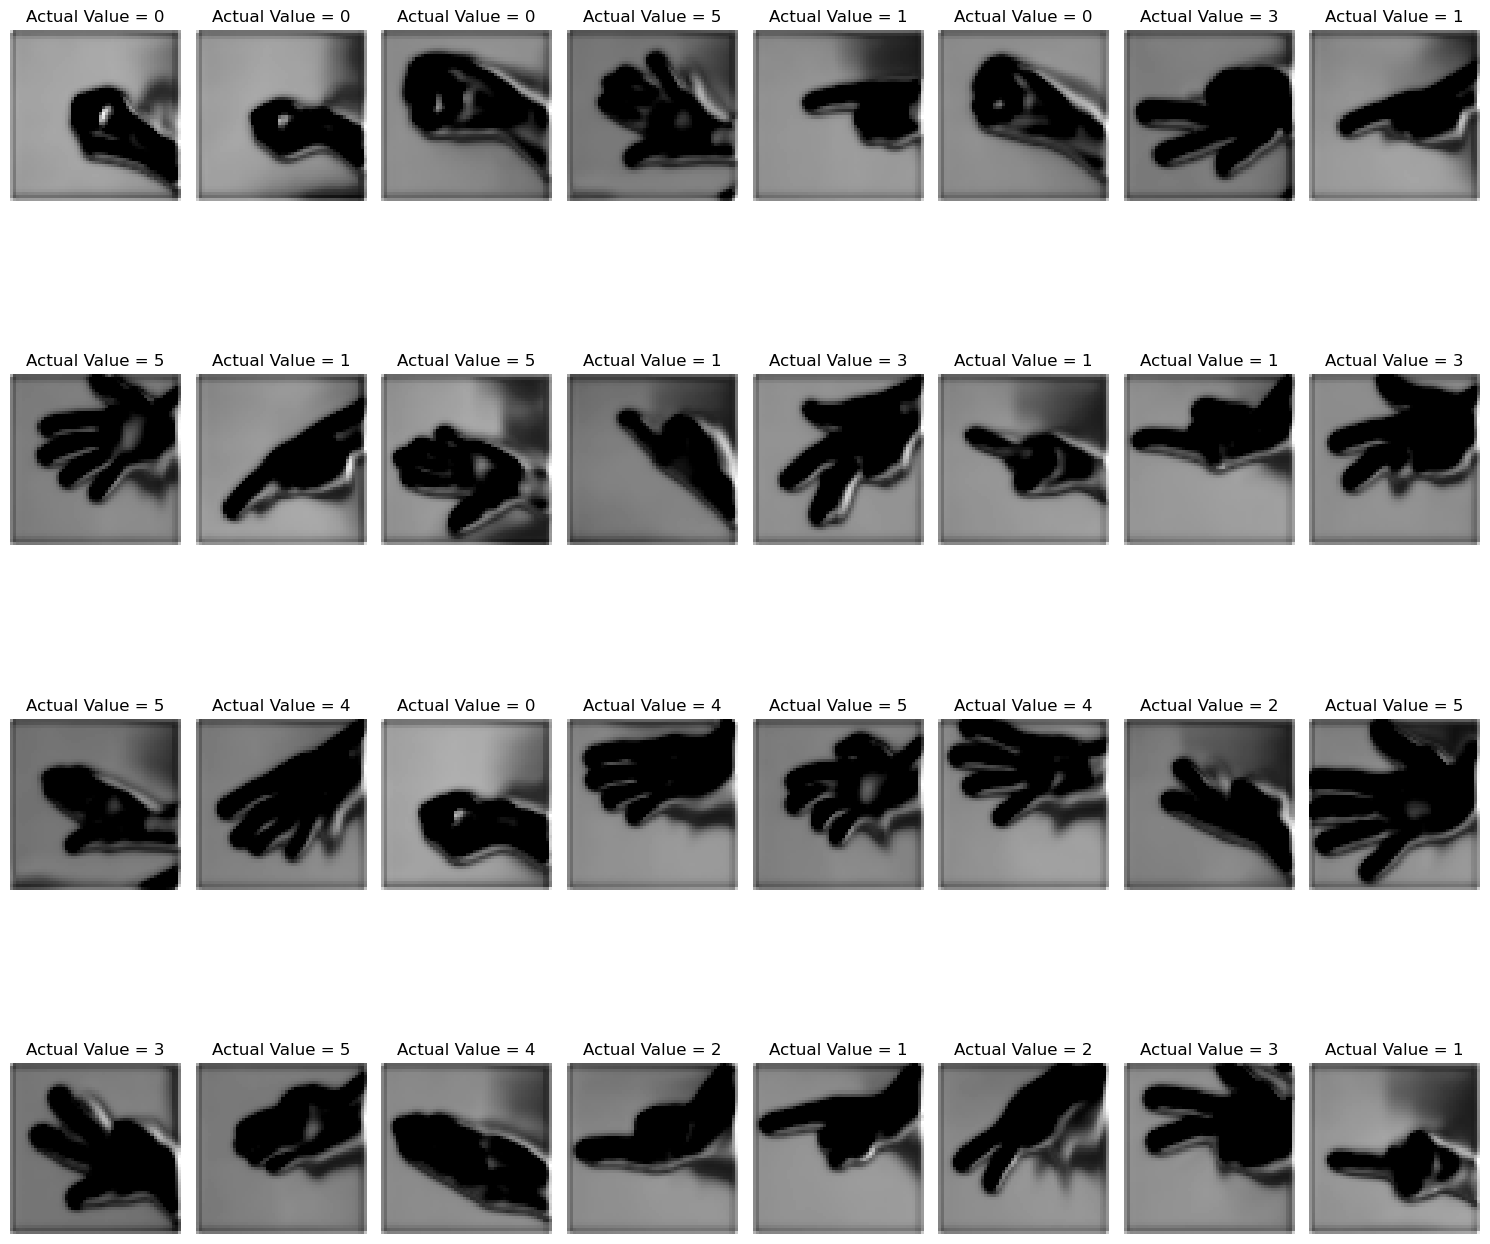

In [22]:
values = outputs["res0"].detach().numpy()

fig, ax = plt.subplots(4,8,figsize=(15,15))

for i, ax in enumerate(ax.flat):
    if i < values.shape[0]:
        # plt.gray()
        ax.imshow(values[i][0].T)
        ax.set_title(f'Actual Value = {labels[i]}')
        ax.axis('off')


plt.tight_layout()
plt.show()

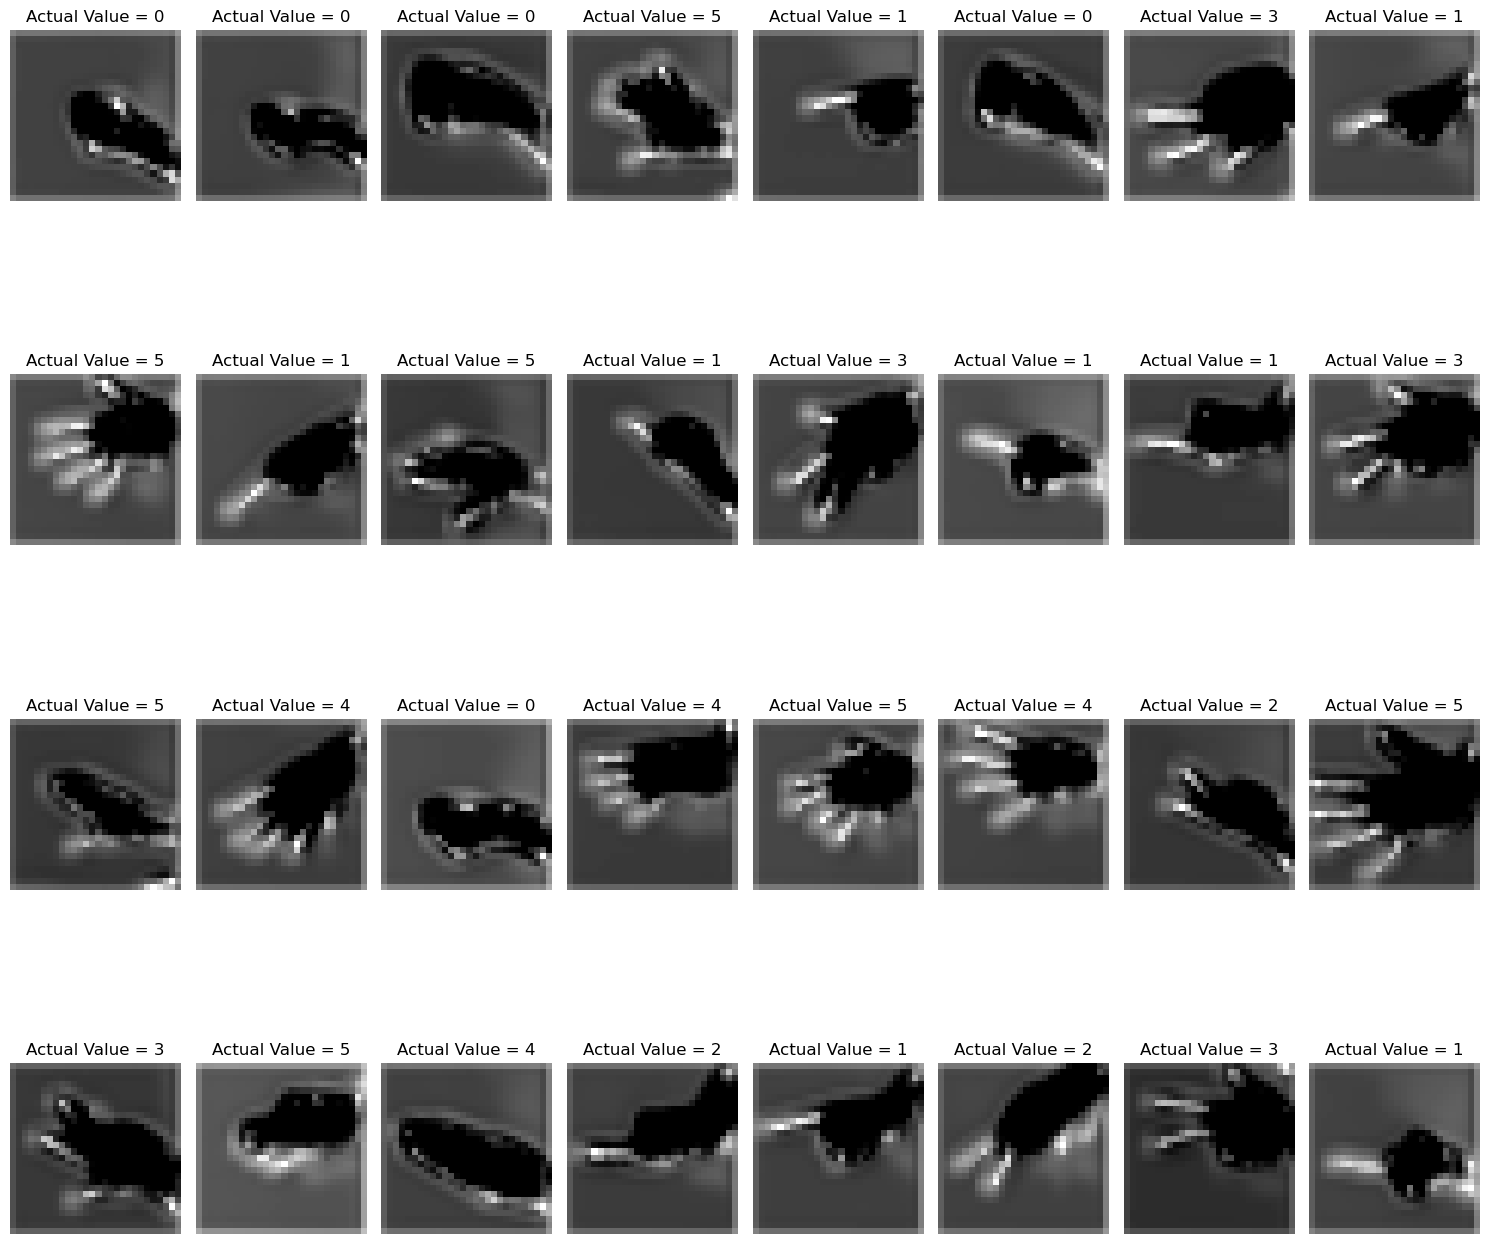

In [23]:
values = outputs["res1"].detach().numpy()

fig, ax = plt.subplots(4,8,figsize=(15,15))

for i, ax in enumerate(ax.flat):
    if i < values.shape[0]:
        # plt.gray()
        ax.imshow(values[i][0].T)
        ax.set_title(f'Actual Value = {labels[i]}')
        ax.axis('off')


plt.tight_layout()
plt.show()

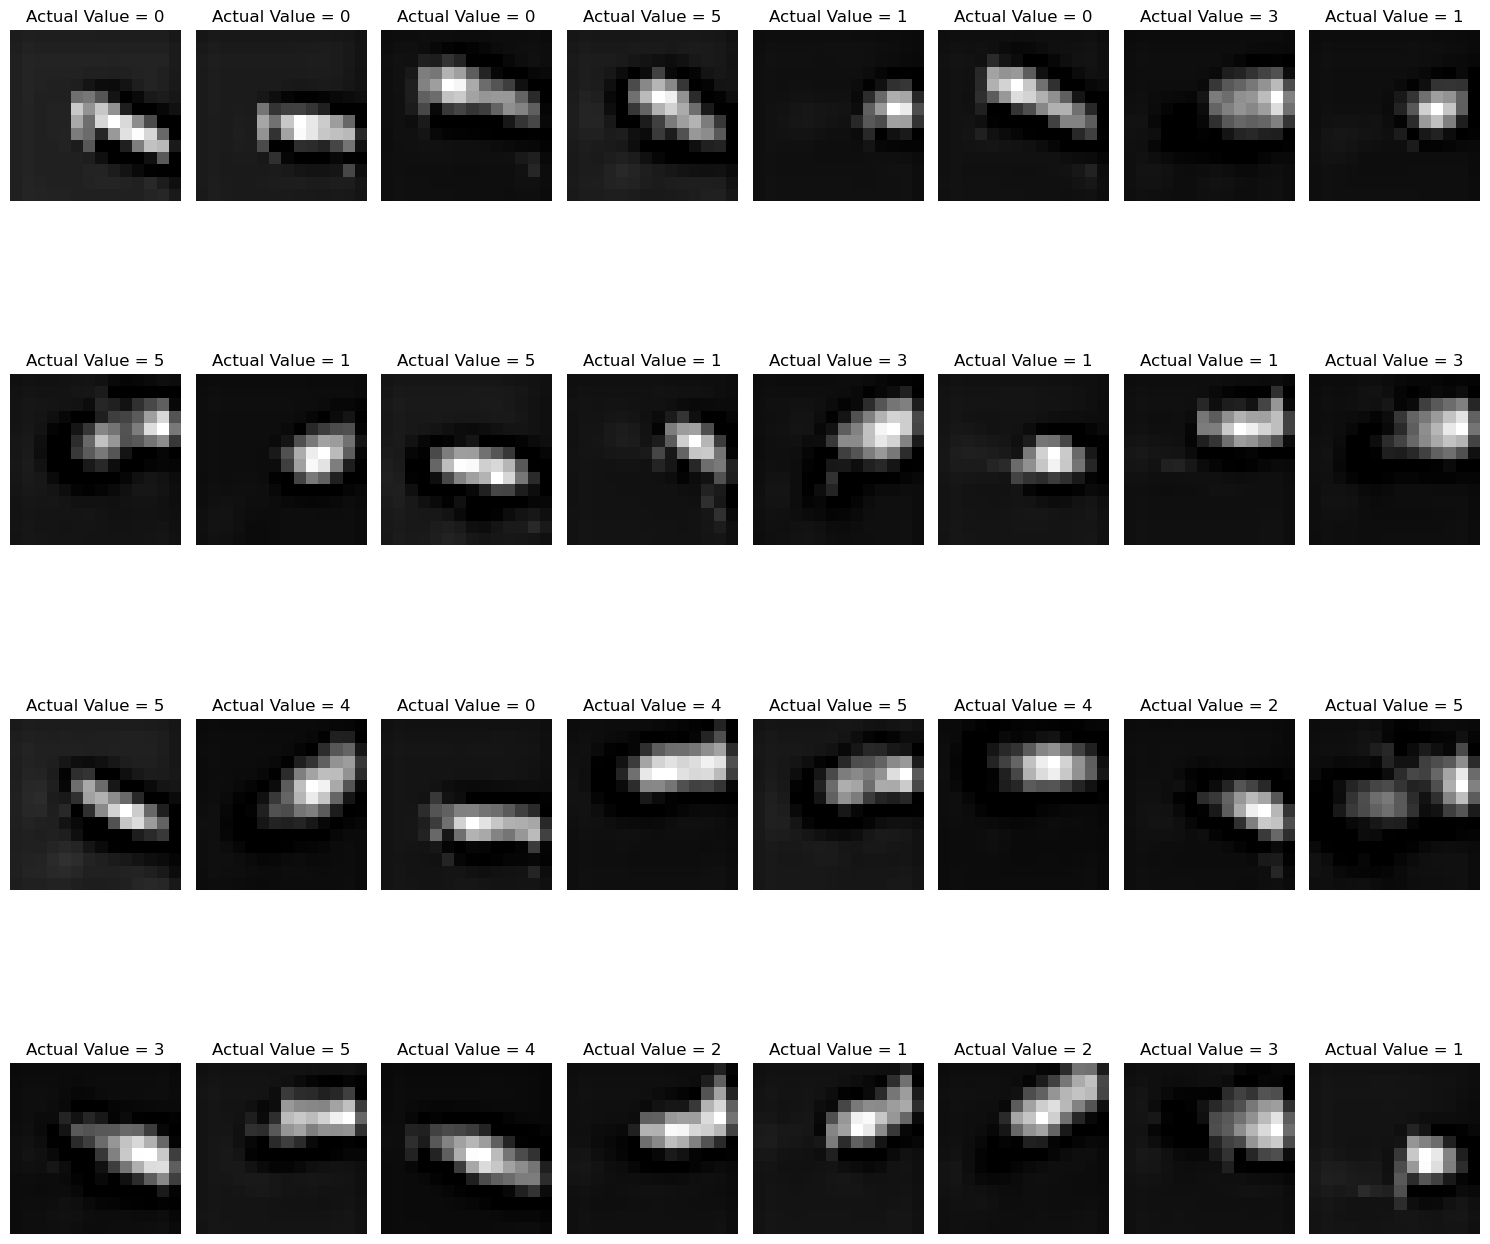

In [24]:
values = outputs["res2"].detach().numpy()

fig, ax = plt.subplots(4,8,figsize=(15,15))

for i, ax in enumerate(ax.flat):
    if i < values.shape[0]:
        # plt.gray()
        ax.imshow(values[i][0].T)
        ax.set_title(f'Actual Value = {labels[i]}')
        ax.axis('off')


plt.tight_layout()
plt.show()

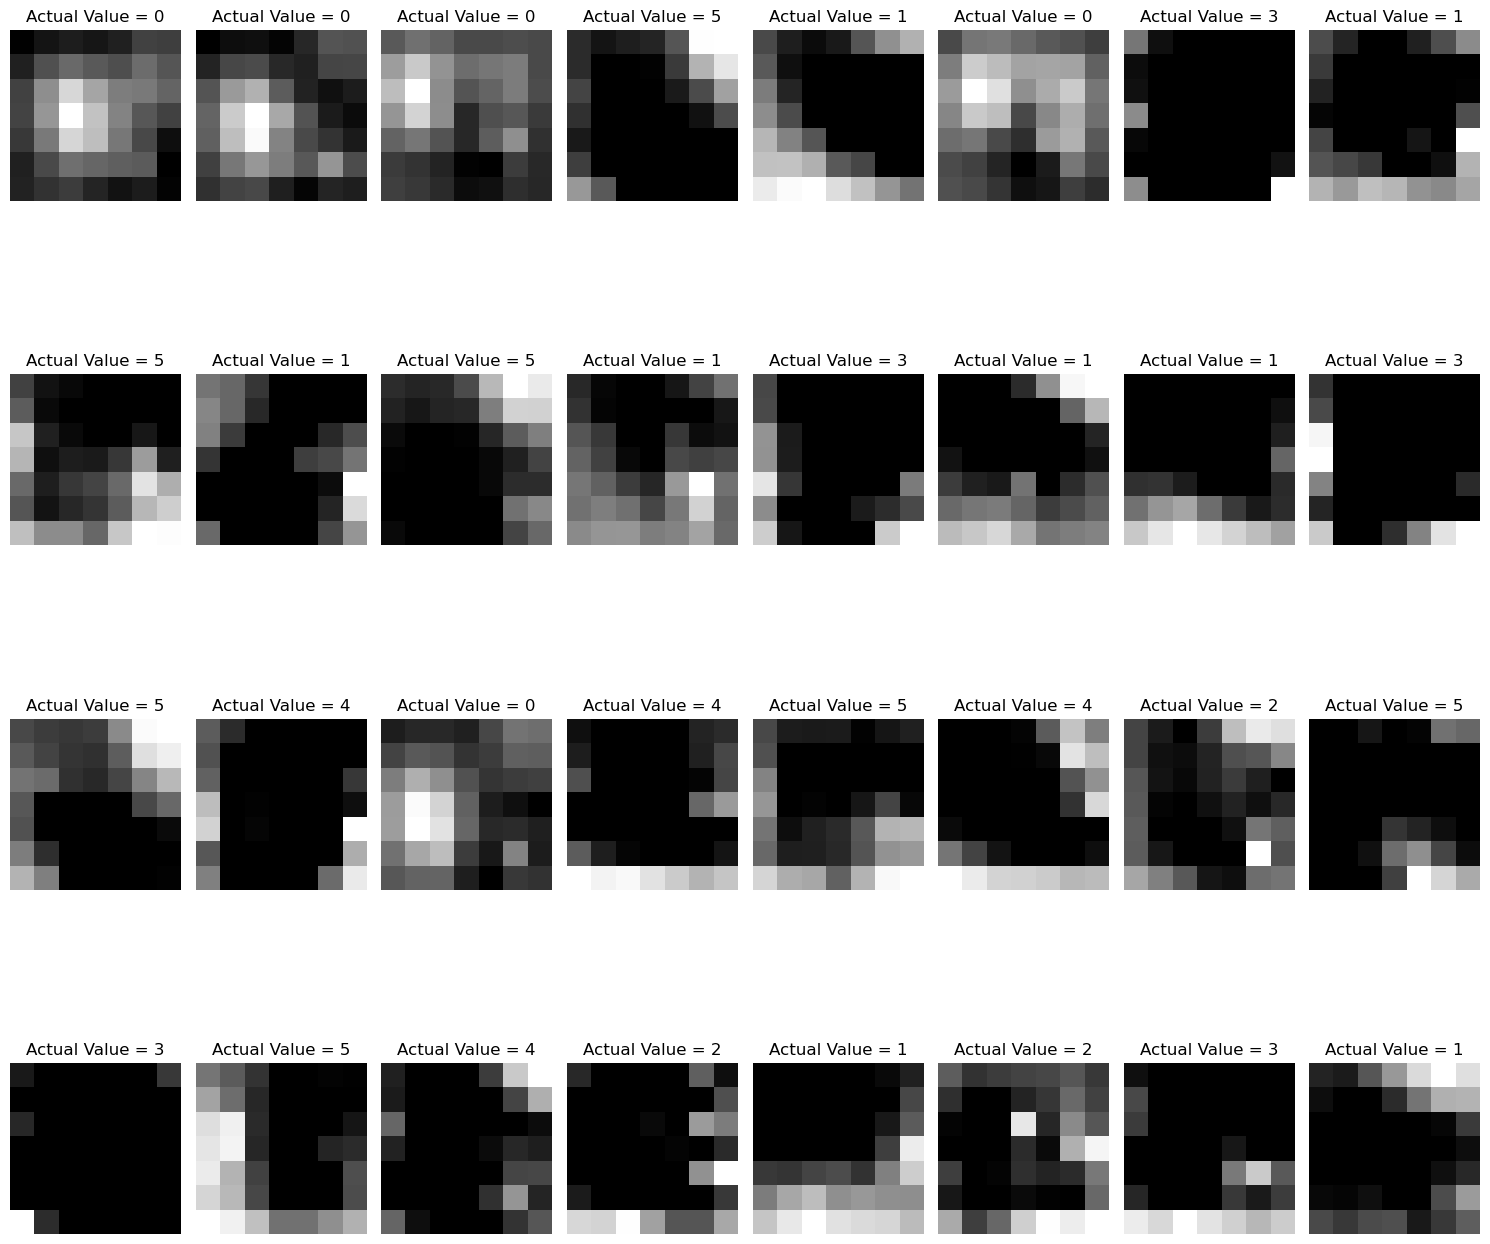

In [25]:
values = outputs["res3"].detach().numpy()

fig, ax = plt.subplots(4,8,figsize=(15,15))

for i, ax in enumerate(ax.flat):
    if i < values.shape[0]:
        # plt.gray()
        ax.imshow(values[i][0].T)
        ax.set_title(f'Actual Value = {labels[i]}')
        ax.axis('off')


plt.tight_layout()
plt.show()